In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f as f_test
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Project Description
You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

(The important thing is to get experience working with data. It doesn't really matter whether you're forecasting 2017 sales based on data from 2016 or 2017 sales based on data from 2016.)

The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

## Data Description
- Name
- Platform: Xbox or PlayStation
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)
Data for 2016 may be incomplete.

## 1. Open the data file and study the general information.

In [2]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

## 2. Prepare the Data
- Replace the column names (make them lowercase).
- Convert the data to the required types.
- Describe the columns where the data types have been changed and why.
- If necessary, decide how to deal with missing values:
  - Explain why you filled in the missing values as you did or why you decided to leave them    blank.
  - Why do you think the values are missing? Give possible reasons.
  - Pay attention to the abbreviation TBD (to be determined). Specify how you intend to handle such cases.
- Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [7]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [8]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

def plt_missing_data(df):
    data_null = df.isnull().sum()/len(df)
    data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)
    plt.subplots(figsize=(40,10))
    plt.xticks(rotation='90')
    sns.barplot(data_null.index, data_null)
    plt.xlabel('Features', fontsize=20)
    plt.ylabel('Missing rate', fontsize=20)

In [9]:
missing_values(df)

,type,count,missing_ratio
name,object,2,0.000120
year_of_release,float64,269,0.016093
genre,object,2,0.000120
critic_score,float64,8578,0.513192
user_score,object,6701,0.400897
rating,object,6766,0.404786


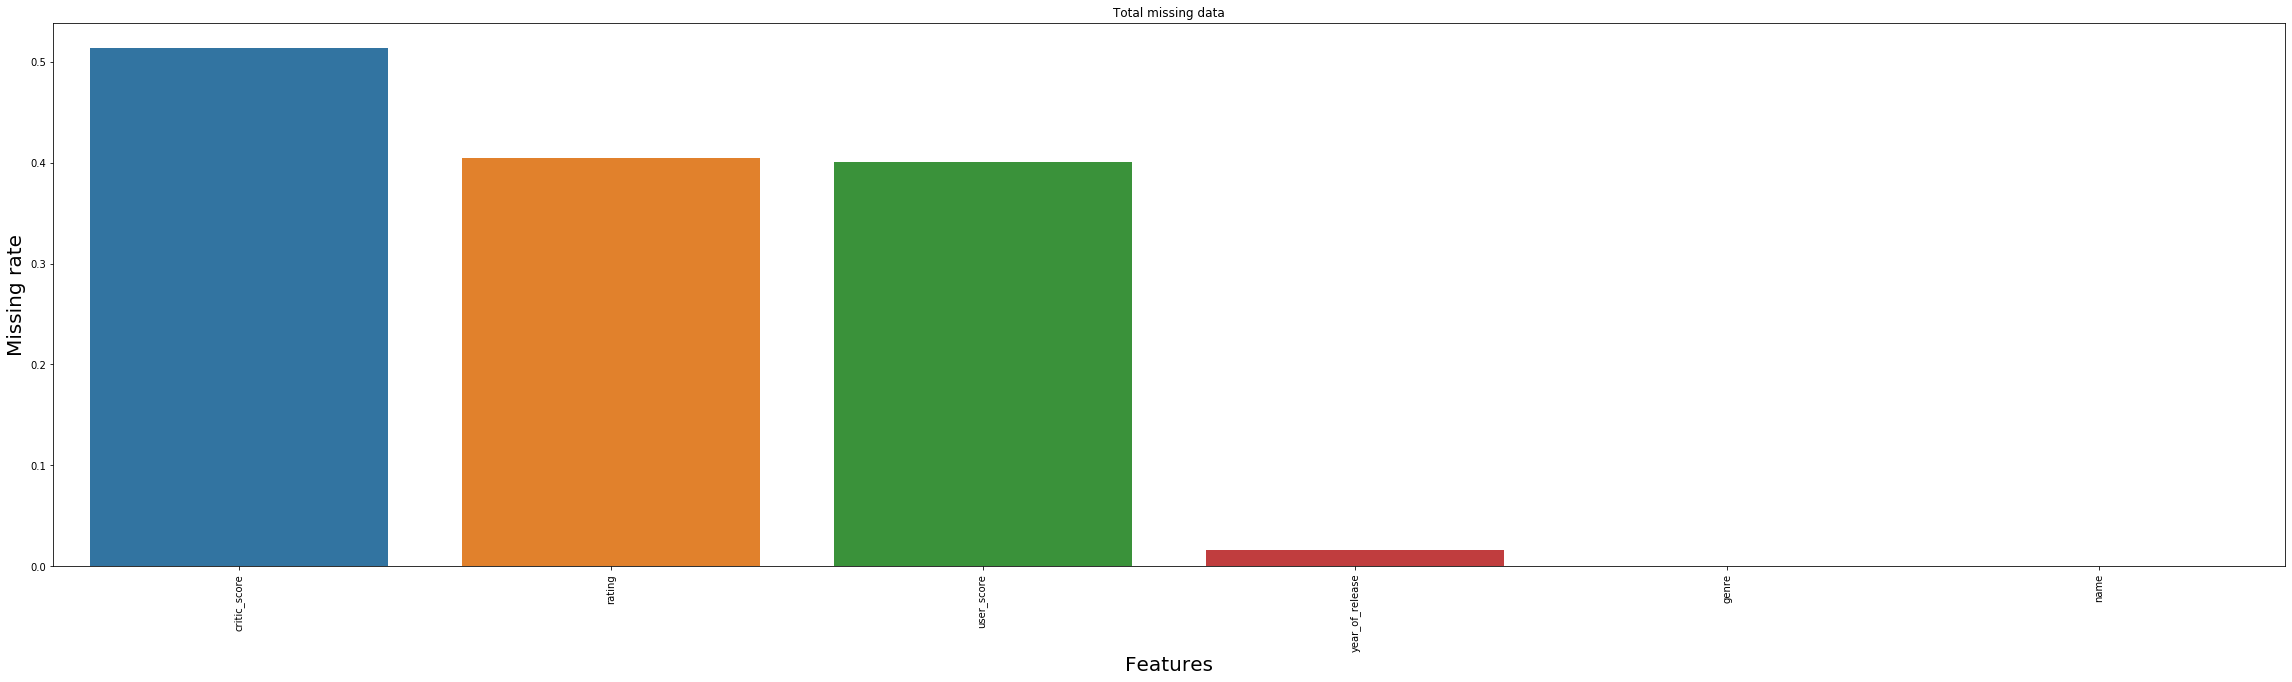

In [10]:
plt_missing_data(df)
plt.title('Total missing data');

We have 6 columns with missing data: *name*, *year_of_release*, *genre*, *critic_score*, *user_score*, and *rating*. The columns *user_score* and *rating* as well as *genre* and *name* interestingly enough have very similar values of missing values.

In [11]:
describe_full(df).T

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446,16715,16715,16715,16715,8137
mean,2006.48,0.263377,0.14506,0.0776171,0.0473419,68.9677
std,5.87705,0.813604,0.503339,0.308853,0.186731,13.9382
min,1980,0,0,0,0,13
25%,2003,0,0,0,0,60
50%,2007,0.08,0.02,0,0.01,71
75%,2010,0.24,0.11,0.04,0.03,79
max,2016,41.36,28.96,10.22,10.57,98
dtypes,float64,float64,float64,float64,float64,float64
Missing %,1.60933,0,0,0,0,51.3192


We can see that the *na_sales*, *eu_sales*, *jp_sales*, and *other_sales* are strongly positively skewed.

In [12]:
col_sales = ['na_sales', 'eu_sales', 'eu_sales', 'jp_sales', 'other_sales']
df["all_sales"] = df[col_sales].sum(axis=1)

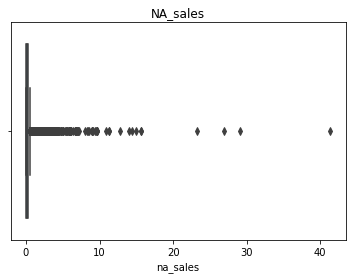

In [13]:
sns.boxplot(df["na_sales"])
plt.title('NA_sales');

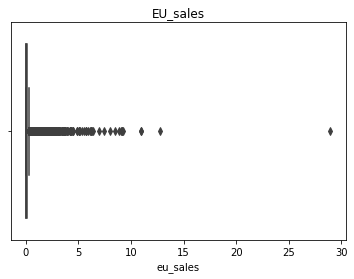

In [14]:
sns.boxplot(df["eu_sales"])
plt.title('EU_sales');

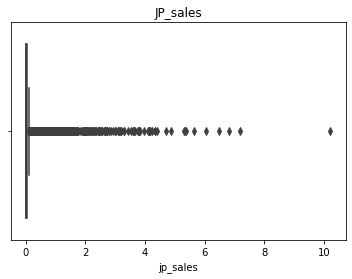

In [15]:
sns.boxplot(df["jp_sales"])
plt.title('JP_sales');

In [16]:
df["platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

I think it's better to convert year from float to int, for simplicity of comparing and etc. We could also convert to datetime, but in this case it does not matter. But first of all we need to deal with impute missing values.

In [17]:
df_missing_year = df[:][df["year_of_release"].isna()].reset_index().drop_duplicates()
df_missing_year

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.50
1,377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,5.86
2,456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,4.03
3,475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,4.02
4,609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+,0.01
265,16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,0.01
266,16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,0.01
267,16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


We don't see any pattern in missing data of *year_of_release*.

In [18]:
df[df["name"]=="Madden NFL 2004"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.50
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E,1.11
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E,0.61
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E,0.39


In [19]:
df[df["name"]=="Space Invaders"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.67
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN,0.46
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN,0.19
10383,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN,0.14


In [20]:
df_missing_year[["name"]].drop_duplicates()

,name
0,Madden NFL 2004
1,FIFA Soccer 2004
2,LEGO Batman: The Videogame
3,wwe Smackdown vs. Raw 2006
4,Space Invaders
...,...
262,Brothers in Arms: Furious 4
263,Agarest Senki: Re-appearance
265,Freaky Flyers
266,Inversion


In [21]:
map_name_year = {r["name"]:r["year_of_release"] for _, r in (df_missing_year[["name"]]
 .drop_duplicates()
 .merge(df[~df["year_of_release"].isna()][["name", "year_of_release"]], how="inner").drop_duplicates()).iterrows()}

In [22]:
df["year_of_release"] = df["year_of_release"].fillna(df["name"].map(map_name_year))

In [23]:
df[df["year_of_release"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,4.02
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T,2.80
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E,2.58
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T,2.65
1142,Rock Band,PS3,NaN,Misc,0.99,0.41,0.00,0.22,92.0,8.4,T,2.03
...,...,...,...,...,...,...,...,...,...,...,...,...
16277,Homeworld Remastered Collection,PC,NaN,Strategy,0.00,0.01,0.00,0.00,86.0,8.2,E10+,0.02
16288,Shorts,DS,NaN,Platform,0.01,0.00,0.00,0.00,NaN,tbd,E10+,0.01
16348,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


We filled in only part of the missing values in the *year_of_release* column, by the *name* column. The rest of the missing values in the *year_of_release* column will be filled by the minimum.

In [24]:
df[df["year_of_release"]==df["year_of_release"].min()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
262,Asteroids,2600,1980.0,Shooter,4.00,0.26,0.0,0.05,NaN,NaN,NaN,4.57
546,Missile Command,2600,1980.0,Shooter,2.56,0.17,0.0,0.03,NaN,NaN,NaN,2.93
1764,Kaboom!,2600,1980.0,Misc,1.07,0.07,0.0,0.01,NaN,NaN,NaN,1.22
1968,Defender,2600,1980.0,Misc,0.99,0.05,0.0,0.01,NaN,NaN,NaN,1.10
2650,Boxing,2600,1980.0,Fighting,0.72,0.04,0.0,0.01,NaN,NaN,NaN,0.81
4019,Ice Hockey,2600,1980.0,Sports,0.46,0.03,0.0,0.01,NaN,NaN,NaN,0.53
5360,Freeway,2600,1980.0,Action,0.32,0.02,0.0,0.00,NaN,NaN,NaN,0.36
6300,Bridge,2600,1980.0,Misc,0.25,0.02,0.0,0.00,NaN,NaN,NaN,0.29
6875,Checkers,2600,1980.0,Misc,0.22,0.01,0.0,0.00,NaN,NaN,NaN,0.24


I assume it's also missing values. There are also missing values in the *critic_score*, *user_score*, and *rating* columns. As we can see, the sales columns have low values of sales. We are going to drop this column.

In [25]:
df = df.drop(df[df["year_of_release"]==df["year_of_release"].min()].index)

In [26]:
df["year_of_release"] = df["year_of_release"].fillna(df["year_of_release"].min()).astype(int)

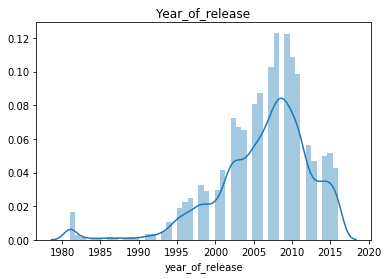

In [27]:
sns.distplot(df["year_of_release"])
plt.title('Year_of_release');

We have a positive skewness shown in the graph above. According to the business model, data that is before 2000, has uncertainty impact on current (2016) picture. Also there are a lot of missing values around these years and it's logically correct.

In [28]:
df[(df["year_of_release"]<1995) & (df["all_sales"]<10)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
89,Pac-Man,2600,1982,Puzzle,7.28,0.45,0.00,0.08,NaN,NaN,NaN,8.26
98,Super Mario Bros. 2,NES,1988,Platform,5.39,1.18,0.70,0.19,NaN,NaN,NaN,8.64
124,The Legend of Zelda,NES,1986,Action,3.74,0.93,1.69,0.14,NaN,NaN,NaN,7.43
137,Street Fighter II: The World Warrior,SNES,1992,Fighting,2.47,0.83,2.87,0.12,NaN,NaN,NaN,7.12
145,Sonic the Hedgehog 2,GEN,1992,Platform,4.47,1.20,0.16,0.19,NaN,NaN,NaN,7.22
...,...,...,...,...,...,...,...,...,...,...,...,...
16277,Homeworld Remastered Collection,PC,1981,Strategy,0.00,0.01,0.00,0.00,86.0,8.2,E10+,0.02
16288,Shorts,DS,1981,Platform,0.01,0.00,0.00,0.00,NaN,tbd,E10+,0.01
16348,Agarest Senki: Re-appearance,PS3,1981,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,1981,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [29]:
df[df["genre"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.92
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


The rows with the missing *genre* values are old, don't have a name in the *name* column, and a lot of missing values in other columns. We could not use these rows to compute any valuable data.

In [30]:
df = df.drop(df[df["genre"].isna()].index)

In [31]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8567
user_score         6690
rating             6755
all_sales             0
dtype: int64

In [32]:
df.loc[df["year_of_release"].isna(), "year_of_release"] = df["year_of_release"].min()

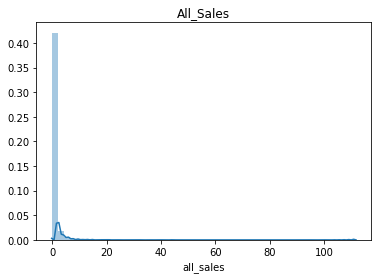

In [33]:
sns.distplot(df["all_sales"])
plt.title('All_Sales');

In [34]:
df[df["critic_score"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,43.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,40.27
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,32.52
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.94
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,35.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.02
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [35]:
describe_full(df, "critic_score")[["corr_with_target"]].T

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,all_sales
corr_with_target,0.019518,0.240755,0.220752,0.152593,0.198554,NaN,0.241945


In [36]:
df["user_score"].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [37]:
df["rating"].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [38]:
df["year_of_release"] = df["year_of_release"].astype(int)

As we see we have "to be determined" value in the user_score column. It's similar to nan in our case and for our model we could replace it by with a blank value.

In [39]:
for col in df.columns:
    df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [40]:
df["user_score"].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

In [41]:
df["genre"] = df["genre"].str.lower()
# df["genre"] = df["genre"].astype("category")

We do not know the rating of a missied row, let's create another category for that. also because there are a lot of rows like that

- EC - Early childhood
- E - Everyone
- E10+ - Everyone 10 and older
- T - Teen
- M - Mature
- AO - Adults Only 18+
- RP - Rating Pending

In [42]:
df.loc[df["rating"].isna(), "rating"] = "NA"

In [43]:
df.duplicated().sum()

0

### Summary
- We found missing values. Missing values by years were restored by name of games partially and some of them were filled by min value
- Missing values of users and critics were replaced by negative value, we couldn't delete them and we couldn't fill them by some value logically
- Also types of year, user_score, critic_score were converted to numerical types, and genre was converted as category

## Step 3. Analyze the data
- Look at how many games were released in different years. Is the data for every period significant?
- Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?
- Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017.
- Work only with the data that you've decided is relevant. Disregard the data for previous years.
- Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.
- Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.
- Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.
- Keeping your conclusions in mind, compare the sales of the same games on other platforms.
- Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

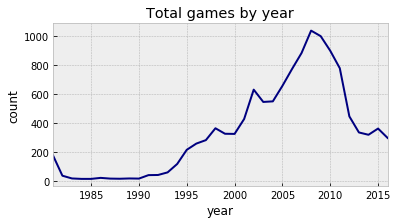

In [44]:
with plt.style.context('bmh'): 
    ((df[['name', 'year_of_release']]
        .drop_duplicates()
        .pivot_table(index='year_of_release', values='name', aggfunc='count')
        .sort_values('year_of_release', ascending=False))
        .plot(figsize=(6, 3), colormap='jet', legend=False, title='Total games by year')
        .set(xlabel='year', ylabel='count'))

As we predicted before, and already saw, data before 1995-2000 is not that interesting to us, those are old games. Also it's incorrect from an economic view, due to inflation the value of money was changed. We can also see how trends have changed over time. Probably after 2008-2010 people play more online games which I believe, are not represented in the dataset.

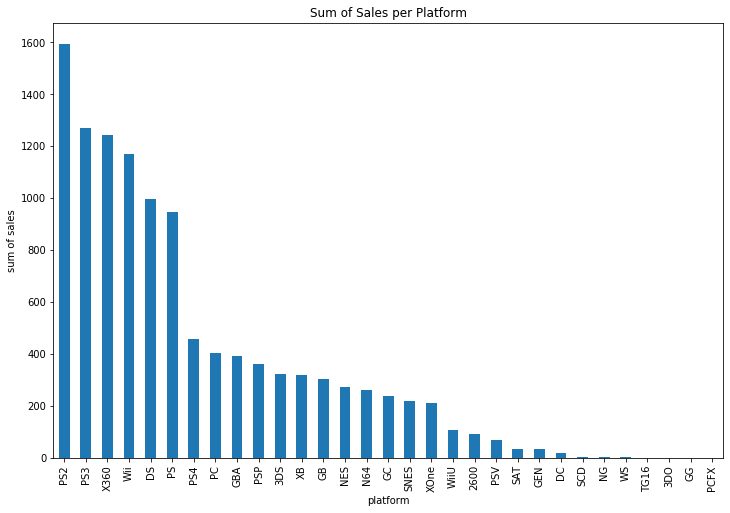

In [45]:
((df.pivot_table(index='platform', values='all_sales', aggfunc='sum')
         .sort_values('all_sales', ascending=False))
   .plot(kind='bar', y='all_sales', figsize=(12, 8), legend=False)
            .set(xlabel='platform', ylabel='sum of sales'))
plt.title('Sum of Sales per Platform');

In [46]:
def display_group_density_plot(df, groupby, on, palette, figsize):
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Distribution of " + on + " per " + groupby + " group"),\
                 fontsize=30)
    
    ax.set_xlabel(on, fontsize=20)
    return ax

Now, we are going to find the platform with the highest sales and plot the density for them.

In [47]:
top10_platforms = (df
 .pivot_table(index='platform', values='all_sales', aggfunc='sum')
 .sort_values('all_sales', ascending=False)).head(10)
top10_platforms

,all_sales
platform,
PS2,1595.06
PS3,1269.94
X360,1242.18
Wii,1169.72
DS,995.01
PS,944.47
PS4,455.23
PC,401.96
GBA,393.10


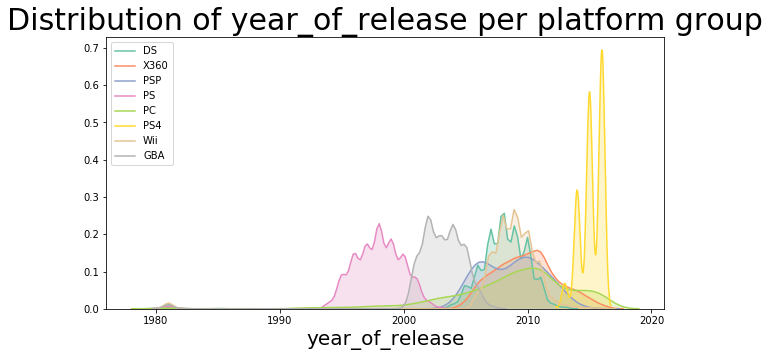

In [48]:
display_group_density_plot(df[df["platform"].isin(top10_platforms.index)], groupby = "platform", on = 'year_of_release', \
                                           palette = sns.color_palette('Set2'), 
                           figsize = (10, 5))
plt.show();

As we see some of platforms were popular in different time periods, and none of top 10 platforms with the highest sales were not popular before 1995.

In [49]:
df = df[(df['year_of_release'] > 1995) & (df['year_of_release'] <= 2016)]

In [50]:
all_sales_per_platform =df.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values('all_sales', ascending=False)

In [51]:
platforms = list(all_sales_per_platform.index)

Now, we are going to plot sales for different platforms.

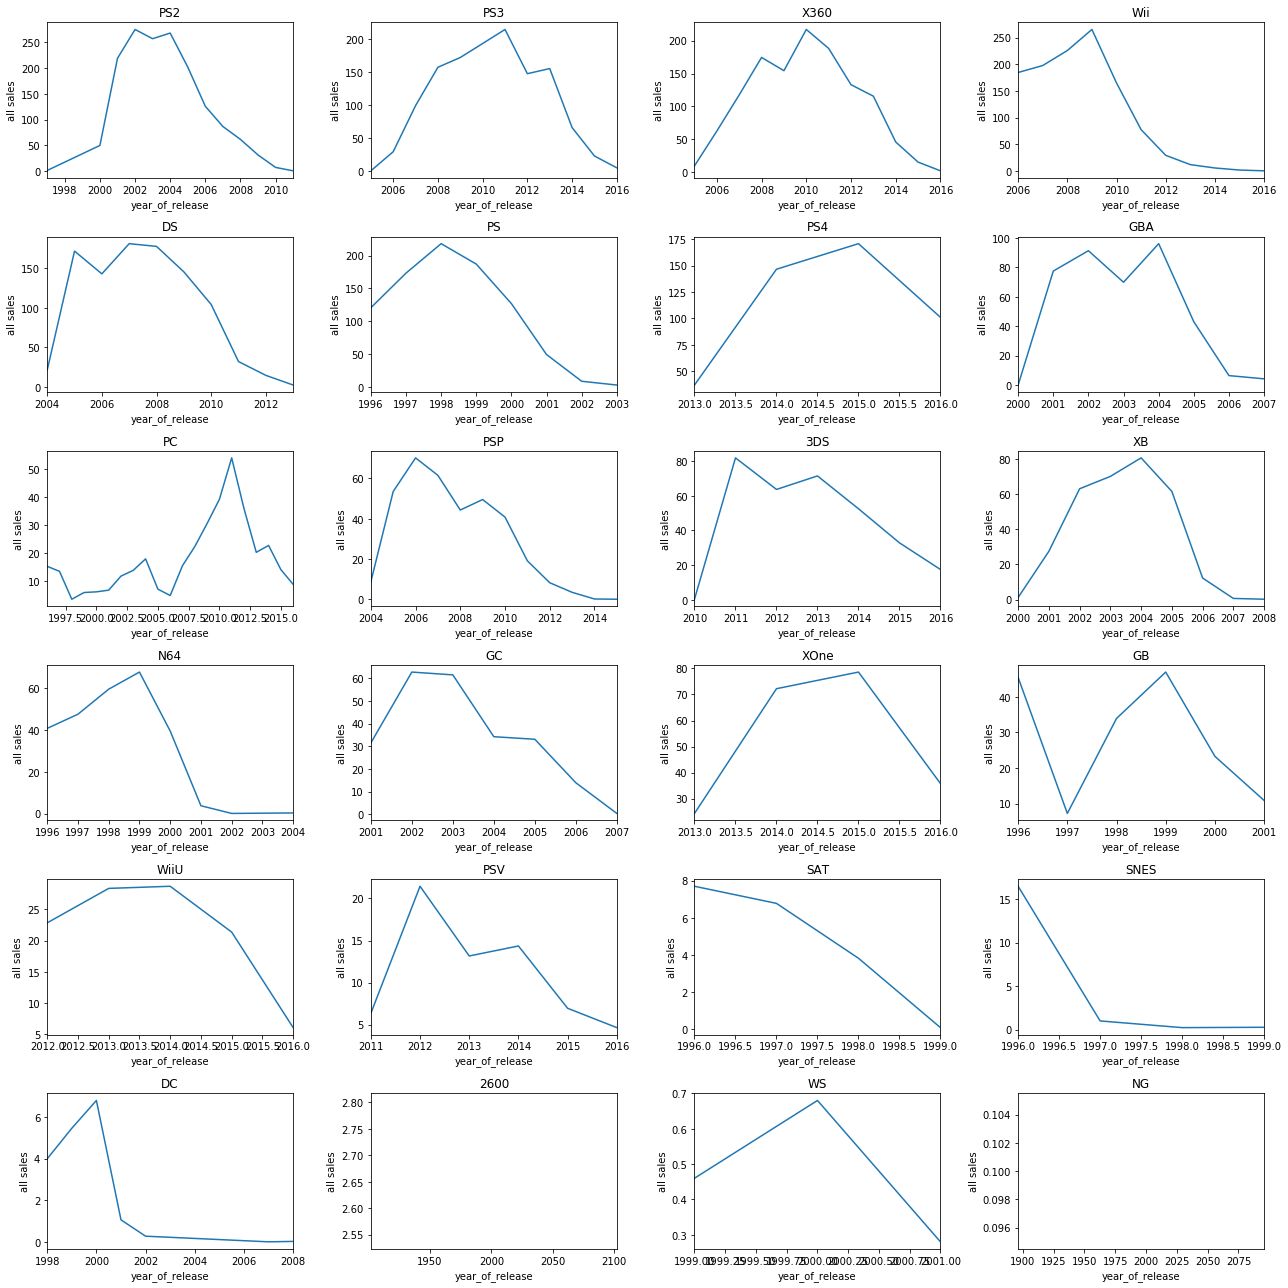

In [52]:
fig, axs = plt.subplots(6, len(platforms) // 6)
axs = axs.flatten()

num = 0
for platform, ax in zip(platforms, axs):
     ((df[df["platform"]==platform]
            .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
            .sort_values('year_of_release', ascending=False))['all_sales']
                .plot(ax=ax, figsize=(18, 18), title=platform)
                .set(xlabel='year_of_release', ylabel='all sales'))
   
    
plt.tight_layout()
plt.show()

According to the above plots, our assumption that sales have decreased over the years is cooroborated. Some of the plots like WS are non-existant today. It is interesting how much more popular PS4 is compared to other platforms.

In [53]:
list(top10_platforms.index)

['PS2', 'PS3', 'X360', 'Wii', 'DS', 'PS', 'PS4', 'PC', 'GBA', 'PSP']

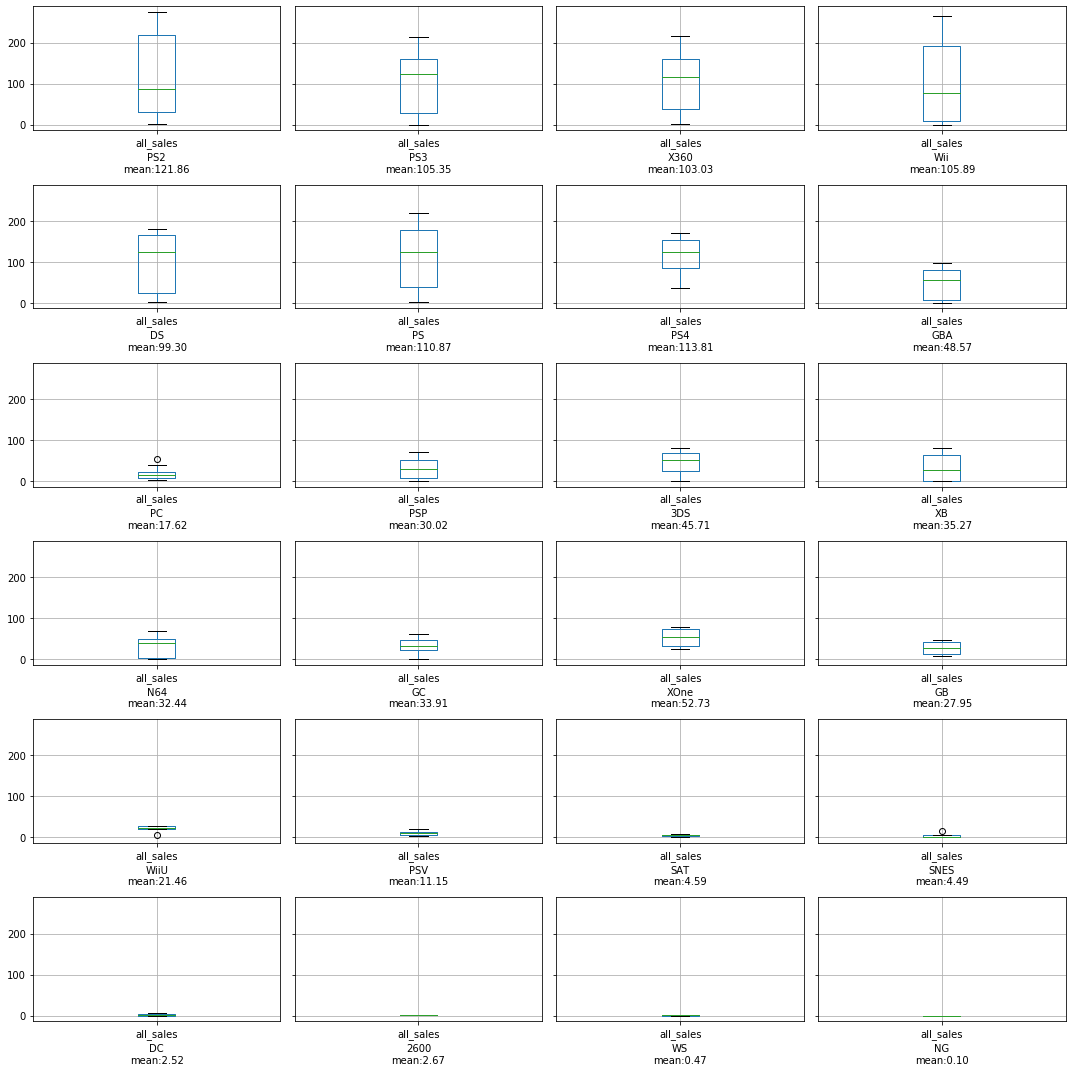

In [54]:
fig, axs = plt.subplots(6, len(platforms) // 6, figsize=(15,15), sharey=True)
axs = axs.flatten()

num = 0
for platform, ax in zip(platforms, axs):
    pivot = ((df[df["platform"]==platform]
            .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
            .sort_values('year_of_release', ascending=False)))
    (pivot.boxplot("all_sales", ax=ax)
                .set(xlabel=f"{platform}\nmean:{pivot['all_sales'].mean():.2f}"))
   

plt.tight_layout()
plt.show();

Based off of the boxplot above, we notice that the Xbox(XOne and etc), PS systems, and Wii are the most valuable. Some old platforms like DC, NG, and WS have slightly visible sales compares to other platforms.

Now we are going to check how *user_score* and *critic_score* impact sales for the Xbox series platform. 

In [55]:
xbox = df[df["platform"].isin(["X360", "XOne", "XB"])].dropna()

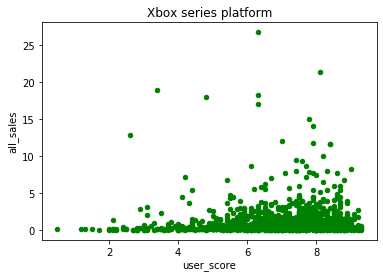

In [56]:
xbox.plot(x='user_score', y='all_sales', kind='scatter', title='Xbox series platform', color='green')
plt.show();

In [57]:
xbox[['user_score', 'critic_score', 'all_sales']].corr().style.background_gradient(cmap=sns.light_palette("green", as_cmap=True))

,user_score,critic_score,all_sales
user_score,1,0.585825,0.0418773
critic_score,0.585825,1,0.336658
all_sales,0.0418773,0.336658,1


There appears to be correlation between *critic_score* and *user_score*.

In [58]:
df[df["platform"].isin(top10_platforms.index)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,111.50
2,Mario Kart Wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,48.28
3,Wii Sports Resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,43.70
6,New Super Mario Bros.,DS,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,38.94
7,Wii Play,Wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E,38.09
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002,platform,0.01,0.00,0.00,0.00,NaN,NaN,NA,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,racing,0.00,0.00,0.00,0.00,NaN,NaN,NA,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,NA,0.01
16711,LMA Manager 2007,X360,2006,sports,0.00,0.01,0.00,0.00,NaN,NaN,NA,0.02


In [59]:
top10_games = (df
 .pivot_table(index='name', values='all_sales', aggfunc='sum')
 .sort_values('all_sales', ascending=False)).head(10)

In [60]:
top10_games

,all_sales
name,
Wii Sports,111.50
Grand Theft Auto V,80.00
Mario Kart Wii,48.28
Wii Sports Resort,43.70
Call of Duty: Modern Warfare 3,41.75
Pokemon Red/Pokemon Blue,40.27
Call of Duty: Black Ops II,40.24
Call of Duty: Black Ops,40.17
New Super Mario Bros.,38.94


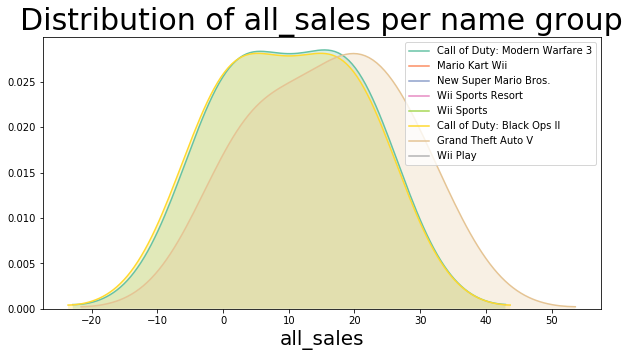

In [61]:
display_group_density_plot(df[df["name"].isin(top10_games.index)], groupby = "name", on = 'all_sales', \
                                           palette = sns.color_palette('Set2'), 
                           figsize = (10, 5))
plt.show();

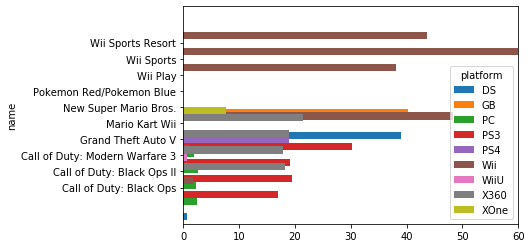

In [62]:
pd.pivot_table(df[df["name"].isin(top10_games.index)], values = 'all_sales', index = 'name',
               columns = 'platform',aggfunc ='sum').plot.barh(width=4)
plt.xlim([0, 60])
plt.show();

In [63]:
df[df["name"]=="Call of Duty: Black Ops II"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
34,Call of Duty: Black Ops II,PS3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,19.52
35,Call of Duty: Black Ops II,X360,2012,shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,17.92
1227,Call of Duty: Black Ops II,PC,2012,shooter,0.64,0.69,0.00,0.19,74.0,4.2,M,2.21
4706,Call of Duty: Black Ops II,WiiU,2012,shooter,0.20,0.18,0.00,0.03,81.0,6.9,M,0.59


In [64]:
df[df["name"]=="Wii Sports"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,111.5


Most popular and valuable platforms were on the Wii, PS and Xbox. but as we checked Wii, is an older platform.

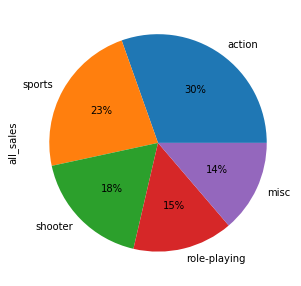

In [65]:
data = (df
            .pivot_table(index="genre", aggfunc='sum')
            .sort_values("all_sales", ascending=False)
            .head(5))
data.plot(kind='pie', y="all_sales",autopct='%1.0f%%', figsize=(10, 5), legend=False).set(label=data.index)
plt.show()

Most valuable genre is action, and if we combine action and shooter, it's the main genre on the market.


## 4. Create a user profile for each region
For each region (NA, EU, JP), determine:
- The top five platforms. Describe variations in their market shares from region to region.
- The top five genres. Explain the difference.
- Do ESRB ratings affect sales in individual regions?

In [66]:
def plot_top_sales_by_region_barplot(df, column, region, n=5):
    data = (df
            .pivot_table(index=column, values=region, aggfunc='sum')
            .sort_values(region, ascending=False)
            .head(n)).reset_index()
    sns.set_color_codes("pastel")
    sns.barplot(y=data[column], x=data[region], data=data, label="sales")
    sns.set_color_codes("muted")
    plt.show();

In [67]:
def plot_top_sales_by_region_pie(df, column, region, n=5):
    data = (df
            .pivot_table(index=column, values=region, aggfunc='sum')
            .sort_values(region, ascending=False)
            .head(n))
    data.plot(kind='pie', y=region,autopct='%1.0f%%', figsize=(10, 5), legend=True).set(label=data.index)
    plt.show();

#### NA / North America

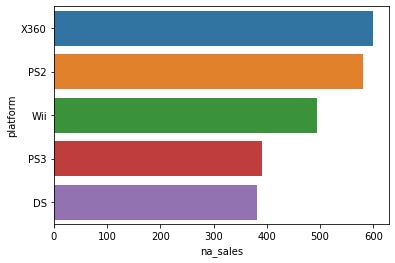

In [68]:
plot_top_sales_by_region_barplot(df, 'platform', region = 'na_sales')

In North America, X360 is popular with the PS2 in second. Both Sony and Microsoft have been in competition with each other in North America for awhile.

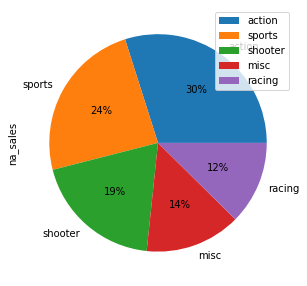

In [69]:
plot_top_sales_by_region_pie(df, 'genre', region = 'na_sales')

The most popular genre is action.
Do ESRB ratings affect sales in individual regions? Let's see.

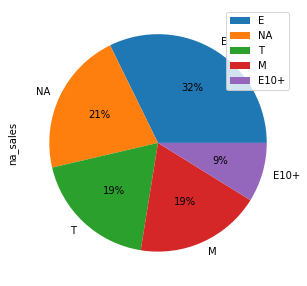

In [70]:
plot_top_sales_by_region_pie(df, 'rating', region = 'na_sales')

- EC - Early childhood
- E - Everyone
- E10+ - Everyone 10 and older
- T - Teen
- M - Mature
- AO - Adults Only 18+
- RP - Rating Pending

Part of ratings were missed, anyway we could see that 32% is E-Everyone rating, 19% is Mature content, the same for teen content, and 9% is for kids. The E category has the highest amount of sales

#### EU / Europe

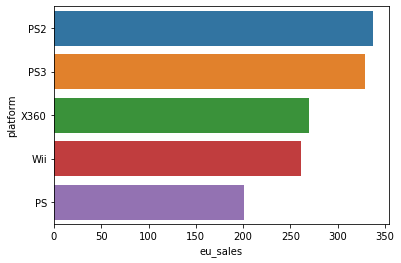

In [71]:
plot_top_sales_by_region_barplot(df, 'platform', region = 'eu_sales')

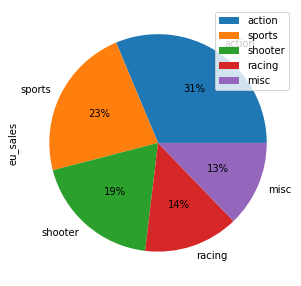

In [72]:
plot_top_sales_by_region_pie(df, 'genre', region = 'eu_sales')

Action and Sports are the most popular genres in Europe, similar to North America.

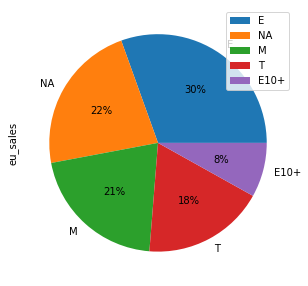

In [73]:
plot_top_sales_by_region_pie(df, 'rating', region = 'eu_sales')

- EC - Early childhood
- E - Everyone
- E10+ - Everyone 10 and older
- T - Teen
- M - Mature
- AO - Adults Only 18+
- RP - Rating Pending

In Europe, the Everyone rating is the most popular, but the Mature rating is more popular here than in North America.

#### JP / Japan

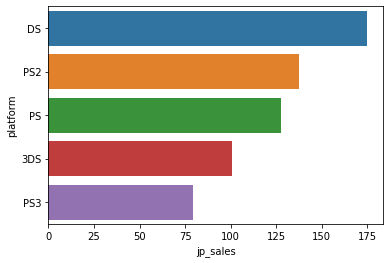

In [74]:
plot_top_sales_by_region_barplot(df, 'platform', region = 'jp_sales')

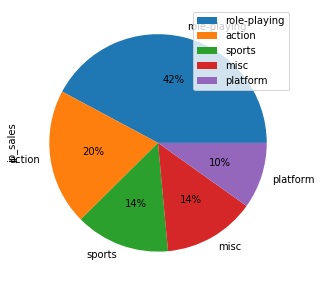

In [75]:
plot_top_sales_by_region_pie(df, 'genre', region = 'jp_sales')

In Japan the situation is different, RPG is most popular.

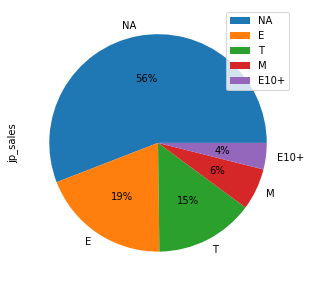

In [76]:
plot_top_sales_by_region_pie(df, 'rating', region = 'jp_sales')

- EC - Early childhood
- E - Everyone
- E10+ - Everyone 10 and older
- T - Teen
- M - Mature
- AO - Adults Only 18+
- RP - Rating Pending

As we can see, there is a lot of missed data is from Japan. Maybe because cartoon-anime games that are kinda hard to recognize, whether it is mature or not, or more logically that they don't use the North American rating system. It also appears that only 4% is for kids, for everyone is around 19%.

#### Summary

In North America:

* In the USA X360 is popular, second one is PS2. Both of these companies have a long history of competing with one another in North America (Microsoft and Sony).
* Action/Sports and Shooter
* everyone and second one - mature 19%/teens 19%

In Europe:

* PS2/PS3
* genre - action and Sports.
* everyone and mature

In Japan:

* DS and PS are popular console
* RPG is the most popular genre
* large part was missed, but most popular are everyone and teens game 


## 5. Test the following hypotheses:
- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.
- Set the alpha threshold value yourself.

Explain:
- How you formulated the null and alternative hypotheses
- What significance level you chose to test the hypotheses, and why

alpha = 0.05 is a good significance level to test the hypotheses because I only have a 5% chance of concluding that a difference exits where there is no actual difference in the data.

Let's check: —Average user ratings of the Xbox One and PC platforms are the same.

$H_0$:—Average user ratings of the Xbox One and PC platforms are the same.

and

$H_1$: —Average user ratings of the Xbox One and PC platforms are different.

In [77]:
alpha = 0.05

In [78]:
df["platform"].unique()

array(['Wii', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'GBA', 'PS4', '3DS',
       'N64', 'PS', 'XB', 'PC', 'PSP', 'XOne', 'WiiU', 'GC', 'SNES',
       '2600', 'DC', 'PSV', 'SAT', 'WS', 'NG', 'PCFX'], dtype=object)

In [79]:
H_0 = "Average user ratings of the Xbox One and PC platforms are the same."
H_1 = "Average user ratings of the Xbox One and PC platforms are different."

pc = df[df["platform"] == 'PC'].dropna()['user_score'].values
xbox = df[df["platform"].isin(["X360", "XOne", "XB"])].dropna()['user_score'].values

result = stats.ttest_ind(pc, xbox)
print('pvalue:', result.pvalue)

if (result.pvalue < alpha):
    print(H_1)
else:
    print(H_0)
print("checking:")
print(f"pc mean={pc.mean()}")
print(f"xbox mean={xbox.mean()}")

pvalue: 0.684228796819557
Average user ratings of the Xbox One and PC platforms are the same.
checking:
pc mean=7.0520114942528735
xbox mean=7.024922504649721


Let's check: —Average user ratings of the Xbox One and PC platforms are the same.

$H_0$:—Average user ratings of the Xbox One and PC platforms are the same.

and

$H_1$: —Average user ratings for the Action and Sports genres are different.

In [80]:
H_0 = "Average user ratings for the Action and Sports genres are the same."
H_1 = "Average user ratings for the Action and Sports genres are different."

action = df[df["genre"] == 'action'].dropna()['user_score'].values
sports = df[df["genre"] == 'sports'].dropna()['user_score'].values

result = stats.ttest_ind(action, sports)
print('pvalue:', result.pvalue)

if (result.pvalue < alpha):
    print(H_1)
else:
    print(H_0)
print("checking:")
print(f"action mean={action.mean()}")
print(f"sports mean={sports.mean()}")

pvalue: 0.9469188193606457
Average user ratings for the Action and Sports genres are the same.
checking:
action mean=7.097120575884823
sports mean=7.100929752066115


## 6. Write a general conclusion
- Platforms that are before 2005, are gone. Others are still in the market but also in the process of disappearing.
- Most popular are PlayStation and Xbox. Most popular genre are Action, Shooter, except Japan, where RPG is most popular
- As we saw it's region specific business.
- Average user ratings of the Xbox One and PC platforms are different.
- Average user ratings for the Action and Sports genres are different.
- Also need research specific platform, big gap between most popular platform and the others